# Lab 3: Sequence-to-Sequence Modeling with Recurrent Neural Networks


The objective of this lab is to _implement, train, and evaluate a recurrent neural network (RNN)-based sequence-to-sequence (seq2seq) model_. Well, that's a mouthful, so let's unpack the two key terms.

A **Recurrent Neural Network** (RNN) is a type of neural network designed to handle sequences, like text or speech. It processes one item of the sequence at a time and carries a hidden state—a kind of short-term memory—that summarises the history of the sequence observed so far. The same weights are reused at each time step, letting it learn patterns over time.


**Sequence-to-sequence learning** is a framework used for tasks in which both the input and the output are variable-length sequences that are not necessarily aligned, such as machine translation or summarization. Nowadays, in general-purpose AI models most tasks are framed as seq2seq, where both the input (e.g., task instructions and a question) and the output (e.g., a reasoning trace and an answer) are sequences.

In this lab, we apply the seq2seq RNN to a toy task, the SCAN dataset, mapping a sequence of textual instructions into a sequence of actions. With all due differences, this is the stripped down version of commanding a robot!

**Important**: Not all student pairs will be able to complete all sections and exercises of this lab: and that is fine! Most students should be able to reach the end of section 7 ("Evaluating the model"). If you do not manage to complete Section 8 ("Out-of-distribution generalisation") in time during the lab session, you are invited to revisit it at your own convenience.

## What you will learn in this lab

### Tools and practical issues:

In this lab, you will learn:
- how to preprocess and batch examples when they have different lengths
- how to implement a sequence-to-sequence model
- how to train this model through stochastic gradient descent
- how to evaluate your model's predictions on a series of metrics, which measure exact match and overlap wrt a reference
- to read the documentation of a library and use it

### Concepts: sequence-to-sequence models and generalisation

After working through the lab, you should be able to:
- explain the different challenges in sequence to sequence modelling
- understand the difference between i.i.d. and out-of-distribution generalisation
   
You should also understand more clearly:
- how neural models are optimised
- how choices in the neural model architecture affect its accuracy

# 1. Install and import dependencies

Let's first install and import the necessary dependencies. Most notably:



*   `torch` (Pytorch), a library for implementing deep learning models, training them, and evaluating them.
*   `wandb` (Weights & Biases), a library to track metrics from your experiments.

_Optional: If you are not familiar with the other libraries, you can find the documentation for most of them on https://docs.python.org/3/library/_

In [2]:
!pip install -q wandb
!pip install -q evaluate
!pip install -U -q datasets

import random
import numpy as np
import json
import os
from tqdm import tqdm
from collections import Counter, defaultdict

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import evaluate

# Tracking
import wandb

# Set random seeds to make our experiments (almost) deterministic
# This makes it easier to reproduce results
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# 2. Compositionality and the SCAN dataset

**Compositional generalisation** is the ability to understand and produce a potentially infinite number of novel combinations from known components. This is the case of natural language, where infinite sentences can be construed from a finite number of words.

For example, assume a person knows the meaning and usage of words such as "*twice*" and "*again*" and then learns a new (imaginary) verb such as "*to dax*". Through compositional generalisation, they can immediately understand or produce instructions such as "*dax twice*" or "*dax again*" even if they haven't encountered these specific combinations before.

With the growing capabilities of machine learning models, researchers have become increasingly interested in testing whether such models can replicate this key aspect of human language.
To support systematic investigation of this question, the **SCAN dataset** was introduced by [Lake and Baroni (2018)](https://github.com/brendenlake/SCAN/blob/master/README.md).

SCAN consists of a set of commands and their corresponding action sequences. These are the actions an agent should perform to execute the commands successfully. The commands and actions are defined compositionally based on primitive verbs ("*jump*", "*walk*", "*run*", "*turn*", etc.), modifiers ("*twice*", "*thrice*", "*left*", etc.) and connectors ("*and*", "*after*", etc.). Here are some examples.

|Command | Action sequence |
| --- | --- |
| IN: jump                |                       OUT: JUMP |
| IN: jump left            |                       OUT:  TURN_LEFT JUMP |
| IN: jump around right       |                   OUT: TURN_RIGHT JUMP TURN_RIGHT JUMP TURN_RIGHT JUMP TURN_RIGHT JUMP |
| IN: turn left twice          |                  OUT: TURN_LEFT TURN_LEFT |
| IN: jump thrice               |                 OUT: JUMP JUMP JUMP |
| IN: jump opposite left and walk thrice   |      OUT: TURN_LEFT TURN_LEFT JUMP WALK WALK WALK |
| IN: jump opposite left after walk around left | OUT: TURN_LEFT WALK TURN_LEFT WALK TURN_LEFT WALK TURN_LEFT WALK TURN_LEFT TURN_LEFT JUMP |

In the first part of this lab, we are going to use a random split of the dataset (80% training, 20% test) that is i.i.d. (**independent and identically distributed**). This means that each example is independent from the others and that all examples are drawn from the same probability distribution. In this case, it means that the test set can be expected to exhibit the same properties as the train set.

Let's first download the SCAN dataset files from the internet, then load them into a Python list, where each element is a tuple (input sequence, output sequence)

In [3]:
# Download SCAN dataset
!wget https://raw.githubusercontent.com/brendenlake/SCAN/refs/heads/master/simple_split/tasks_train_simple.txt -O train_simple.txt
!wget https://raw.githubusercontent.com/brendenlake/SCAN/refs/heads/master/simple_split/tasks_test_simple.txt -O test_simple.txt

def load_scan_file(file_path):
    with open(file_path) as f:
        data = [line.strip().split(" OUT: ") for line in f.readlines()]
    return [(inp.split()[1:], [x[2:] for x in out.split()]) for inp, out in data]

train_data = load_scan_file("train_simple.txt")
test_data = load_scan_file("test_simple.txt")

--2025-10-20 15:46:47--  https://raw.githubusercontent.com/brendenlake/SCAN/refs/heads/master/simple_split/tasks_train_simple.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3267938 (3.1M) [text/plain]
Saving to: ‘train_simple.txt’

train_simple.txt    100%[===================>]   3.12M  --.-KB/s    in 0.08s   

2025-10-20 15:46:47 (37.0 MB/s) - ‘train_simple.txt’ saved [3267938/3267938]

--2025-10-20 15:46:48--  https://raw.githubusercontent.com/brendenlake/SCAN/refs/heads/master/simple_split/tasks_test_simple.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent,

Let's explore some properties of the SCAN dataset.

The input command is always a combination of the following words:

In [4]:
unique_primitives = set()
for in_out in train_data:
    unique_primitives.update(in_out[0])
print(unique_primitives)

{'jump', 'left', 'look', 'walk', 'and', 'turn', 'after', 'thrice', 'around', 'right', 'twice', 'opposite', 'run'}


...while the output is a combination of the following actions:

In [5]:
unique_actions = set()
for in_out in train_data:
    unique_actions.update(in_out[1])
print(unique_actions)

{'RUN', 'LOOK', 'TURN_LEFT', 'TURN_RIGHT', 'JUMP', 'WALK'}


We will also define a helper function to print out specific examples from our datasets:

In [6]:
def print_example(exm):
    # for formatting the input and output when printing each sample
    input, output = exm
    print(f"IN: {" ".join(input)}")
    print(f"OUT: {" ".join(output)}")

## Exercise 1

1. Can you work out the action sequence corresponding to the following commands? Take a look at the examples above to answer this.

- IN: *jump opposite left*
- IN: *walk around left*
- IN: *run opposite right and look left*
- IN: *look thrice after jump around right*

2. How would you describe the "algorithm" you used to map between the tokens in the input sequence and the actions in the output sequence?

3. What do you notice?

  *   Is there a 1-to-1 mapping between words and actions? NO
  *   Does the order of word spans always correspond to the order in which the corresponding actions appear? No

4. As a final exercise, assume that the model has seen the two following examples during training:


In [7]:
print_example(train_data[544])
print_example(train_data[1043])

IN: jump right twice after walk around right thrice
OUT: TURN_RIGHT WALK TURN_RIGHT WALK TURN_RIGHT WALK TURN_RIGHT WALK TURN_RIGHT WALK TURN_RIGHT WALK TURN_RIGHT WALK TURN_RIGHT WALK TURN_RIGHT WALK TURN_RIGHT WALK TURN_RIGHT WALK TURN_RIGHT WALK TURN_RIGHT JUMP TURN_RIGHT JUMP
IN: jump opposite right after turn opposite right
OUT: TURN_RIGHT TURN_RIGHT TURN_RIGHT TURN_RIGHT JUMP


During evaluation, the model needs to execute the following command:

IN: _jump opposite right after walk around right thrice_

How does the test command relate to the two training commands? How can the model take advantage of this to generalise to this unseen command?

After completing the exercises with your partner, verify your solutions in the companion file.

---

# 3. Data preprocessing



After familiarising ourselves with the SCAN dataset, we will develop a neural network model that can automatically take in a sequence of commands as input, and produce a sequence of actions as output.

To use a neural network to perform this task, we first need to convert both the input and output tokens into a format that can be processed by a neural network, i.e., vector representations.


As you know from week 4, the most widespread approach is to assign each unique token a scalar index and use an `nn.Embedding` layer (from the `torch` library) to learn a dense vector representation for each token, also known as an *embedding*. We will talk more about `nn.Embedding` shortly, but let's focus on assigning token indices for now.

## Exercise 2

As an exercise, fill in the code for the function below, following the specifications in the function descriptor. Also, keep in mind that:
- you should ensure that this mapping is deterministic. You can ensure this by sorting your vocabularies (words and actions) alphabetically.
- you should reserve 3 indices for special tokens in both vocabularies (see below for an explanation of why this is needed): 0 for `<pad>` (padding), 1 for `<bos>` (beginning of sentence), and 2 for `<eos>` (end of sentence).

_Hint_: First create sets of words and actions from the dataset examples, then construct the corresponding dictionaries. In Python, you can update the elements of a `set` with the `update` method and iterate through the indices and elements of a `list` through `enumerate`.

Once you've populated the `build_vocab` function, the code uses the resulting vocabularies to map from words/actions to indices (and viceversa) via the `numericalize` function. Note that this function also maps the output sequence into a **tensor**. This is a `torch` class used to efficiently represent (and perform calculations on) numerical arrays of various dimensions and sizes.

In [11]:
def build_vocab(pairs):
    '''
    This function takes in:
    -  pairs: the list of (input, output) tuples in the training set
    and returns four dictionaries:
    - input_w2i: input word to index
    - input_i2w: index to input word
    - output_w2i: output word to index
    - output_i2w: index to output word
    '''
    ################
    # YOUR CODE HERE
    ################
    input_word_set = set()
    output_word_set = set()
    for input, output in pairs:
        input_word_set.update(input)
        output_word_set.update(output)
    input_w2i = {w:i+3 for i, w in enumerate(sorted(input_word_set))}
    output_w2i = {w:i+3 for i, w in enumerate(sorted(output_word_set))}
    input_w2i["<pad>"] = 0
    input_w2i["<bos>"] = 1
    input_w2i["<eos>"] = 2
    output_w2i["<pad>"] = 0
    output_w2i["<bos>"] = 1
    output_w2i["<eos>"] = 2
    
    input_i2w = {i:w for i,w in input_w2i.items() }
    output_i2w = {w:i for i, w in output_w2i.items()}
    return input_w2i, input_i2w, output_w2i, output_i2w
input_w2i, input_i2w, output_w2i, output_i2w = build_vocab(train_data)

def numericalize(seq, vocab):
    # maps a token to its corresponding unique index
    return torch.tensor([vocab[w] for w in seq])

in_seq, out_seq = train_data[0]

print('Original:')
print('IN:', in_seq)
print('OUT:', out_seq)

print('Indices:')
print('IN:', numericalize(in_seq, input_w2i))
print('OUT:', numericalize(out_seq, output_w2i))


Original:
IN: ['jump', 'opposite', 'right', 'twice', 'and', 'turn', 'opposite', 'right', 'thrice']
OUT: ['TURN_RIGHT', 'TURN_RIGHT', 'JUMP', 'TURN_RIGHT', 'TURN_RIGHT', 'JUMP', 'TURN_RIGHT', 'TURN_RIGHT', 'TURN_RIGHT', 'TURN_RIGHT', 'TURN_RIGHT', 'TURN_RIGHT']
Indices:
IN: tensor([ 6,  9, 10, 14,  4, 13,  9, 10, 12])
OUT: tensor([7, 7, 3, 7, 7, 3, 7, 7, 7, 7, 7, 7])


The three special tokens added to the input and output vocabularies have some special purposes:

**\<eos>**: marks the *end of sequence*. It tells the encoder when the input sequence is finished, and tells the decoder when to stop generating output.

**\<bos>**: marks the *beginning of sequence*. It is used only for the decoder side to signal the beginning of decoding.

**\<pad>**: used for *padding* sequences to a uniform length so that they can be processed in batches.

*These tokens don’t appear in the original SCAN commands or actions, but they’re essential for training and evaluating sequence models properly.*

# 4. Dataloader and batching

Next, let's define `SCANDataset`, a custom Python class to represent our **dataset** (inheriting from `torch.utils.data.Dataset`). Given a sample index, the dataset will return an input-output sequence mapped to the corresponding token indices via `numericalize`.

In [12]:
class SCANDataset(Dataset):
    def __init__(self, data, input_vocab, output_vocab):
        self.data = data
        self.input_vocab = input_vocab
        self.output_vocab = output_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inp, out = self.data[idx]
        input_seq = numericalize(inp + ['<eos>'], self.input_vocab)
        target_seq = numericalize(out + ['<eos>'], self.output_vocab)
        return input_seq, target_seq

**Batching** is the process of grouping multiple examples together and processing them in parallel during training.
Instead of updating the model parameters after seeing just one example at a time, we update them after computing the average loss across a batch of examples.
This leads to faster training and more stable gradient estimates.

However, in sequence-to-sequence tasks, input and output sequences often have variable lengths.
This makes batching challenging, because vectors in a batch must be the same shape in order to stack them together into a matrix.
This is where `collate_fn` comes in.

`collate_fn` is a function that specifies how to combine individual examples into a batch. It is passed to the `DataLoader`, and it handles:

- Padding sequences to the same length, which is the maximum length of any sequence in that batch (so they can be stacked into a matrix).

- Keeping track of original lengths, which is important for models like RNNs to avoid wasting computation on pad tokens.

In [13]:
def collate_fn(batch):
    inputs, targets = zip(*batch)
    # we need to keep track of the lengths of the input sequences
    input_lengths = [len(seq) for seq in inputs]
    inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=input_w2i["<pad>"])
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=output_w2i["<pad>"])
    return inputs, targets, input_lengths

We then use `collate_fn` to create instances of dataloaders for both the train and test splits. It is worth noting that:

- The value of `BATCH_SIZE` is usually a power of 2. The choice represents a trade-off between high values (high memory load, more stable gradients) and low values (low memory load, less stable gradients).
- We shuffle the training data loader to make sure that each batch is a random sample. Technical note: this guarantees that the gradient estimate we obtain on a single batch of examples is unbiased with respect to the true gradient for the whole dataset.

In [14]:
BATCH_SIZE = 32

train_dataset = SCANDataset(train_data, input_w2i, output_w2i)#将字符转为vector
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

test_dataset = SCANDataset(test_data, input_w2i, output_w2i)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

Here are a few example batches from the train_loader:

In [15]:
inputs, targets, input_lengths = next(iter(train_loader))

print("Input tensor (padded) has shape:", inputs.shape, "\n")
print(f'This means there are {inputs.shape[0]} training samples (input sequences), with all the sequences padded to {inputs.shape[1]} tokens as the max length\n')
print('Below is the first batch of input sequences:\n')
print(inputs, "\n")
print('(recall 0 is the index for the <pad> token)\n')
print("Actual lengths of the 32 input sequences:", input_lengths, "\n")
print("Output tensor (padded) has shape:", targets.shape, "\n")
print(f'This means there are {targets.shape[0]} training samples (output sequences), with all the sequences padded to {targets.shape[1]} tokens as the max length\n')
print('Below is the first batch of output sequence:\n')
print(targets, "\n")


Input tensor (padded) has shape: torch.Size([32, 10]) 

This means there are 32 training samples (input sequences), with all the sequences padded to 10 tokens as the max length

Below is the first batch of input sequences:

tensor([[ 6,  9, 10, 12,  3,  6,  9, 10, 12,  2],
        [13,  5, 10,  4, 11,  2,  0,  0,  0,  0],
        [ 8,  9, 10, 14,  4, 15,  5, 10, 14,  2],
        [ 8, 10, 14,  3, 15,  5, 10, 12,  2,  0],
        [ 8,  9,  7, 12,  3,  8,  2,  0,  0,  0],
        [13,  9, 10,  4,  6,  9,  7, 12,  2,  0],
        [11,  9, 10,  4, 13,  5, 10,  2,  0,  0],
        [15,  5,  7, 14,  4,  8,  9,  7,  2,  0],
        [11,  5, 10, 14,  3, 11,  9,  7, 14,  2],
        [15,  9,  7, 14,  4, 15, 14,  2,  0,  0],
        [ 6,  5,  7, 14,  4, 11,  9, 10,  2,  0],
        [ 8,  7, 12,  4, 13, 10,  2,  0,  0,  0],
        [11,  7,  3, 13,  5,  7, 14,  2,  0,  0],
        [ 6,  9, 10,  4, 11,  9, 10,  2,  0,  0],
        [ 6,  7, 12,  3, 13,  5, 10, 14,  2,  0],
        [ 6,  3,  6,  9,  

# 5. Sequence-to-sequence model

Let's start implementing in `torch` our recurrent model, which consists of an encoder and a decoder:

- the **encoder** maps the input sequence of words into a sequence of hidden representations.
- the **decoder** maps the sequence of hidden representations into a sequence of actions.

We will implement a kind of recurrent network called a Gated Recurrent Unit (GRU; [Cho et al. 2014](https://arxiv.org/pdf/1406.1078)). In comparison with vanilla RNNs, GRUs have learnable gates that stabilise learning by avoiding the risk of gradient vanishing and explosion.

The encoder (and the decoder) will consist of a class inheriting from `nn.Module` (via `super().__init__()`): this way, this class will automatically keep track of trainable parameters and their gradients. Both classes contain two methods:

`__init__`: This method defines the architecture of the model by specifying each layer within the model. Each layer is initialized with the appropriate input and output dimensions (and possibly other keyword arguments):

- An `Embedding` layer maps token indices (with `vocab_size` as the size of the vocabulary) to dense vector representations with dimensionality `hidden_size`.

- In the `GRU` layer, the first `hidden_size` indicates the size of each input vector (which is the output of the embedding layer). The second `hidden_size` specifies the size of the GRU's hidden state. These two values are identical in our implementation, but they don't necessarily have to be the same. `num_layers=2` stacks two `GRU` layers, allowing the model to capture more complex temporal dependencies.


`forward`: This method outlines the computation that occurs when data is passed through the layers within the model to produce the output.

In [16]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,
                                      hidden_size)
        self.rnn = nn.GRU(input_size=hidden_size,
                          hidden_size=hidden_size,
                          num_layers=2,
                          batch_first=True)

    def forward(self, input, lengths):
        # input shape: [batch_size, seq_len]
        embedded = self.embedding(input)
        # embedded shape: [batch_size, seq_len, hidden_size]

        # See note below on packing
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded,
            lengths,
            batch_first=True,
            enforce_sorted=False
        )
        x, hidden = self.rnn(packed)
        # hidden shape: [num_layers, batch_size, hidden_size]
        return hidden


## Note on Packing

RNNs, by default, will process the padding tokens as a normal input token unless told otherwise — which wastes computation and add noise to the training.

`pack_padded_sequence` tells the RNN to skip the padding tokens and only compute over the actual (unpadded) content.

## Exercise 3

Now implement the `__init__` method of the `Decoder`. Remember to add:

- an `Embedding` layer, to embed the sequence of decoded output actions.
- 2 `GRU` layers.
- a `Linear` layer (used only in the decoder), which projects vectors of dimensionality `hidden_size` back to `vocab_size` to map hidden states to output actions.

In [25]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        ################
        # YOUR CODE HERE
        ################
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,
                                      hidden_size)
        self.rnn = nn.GRU(input_size = hidden_size, 
                          hidden_size= hidden_size, 
                          num_layers=2,
                          batch_first=True)
        self.out = nn.Linear(hidden_size,
                             vocab_size)
    def forward(self, input, hidden):
        # input shape: [batch_size, 1]
        embedded = self.embedding(input)
        # embedded shape: [batch_size, 1, hidden_size]
        output, hidden = self.rnn(embedded, hidden)
        # hidden shape: [batch_size, 1, hidden_size]
        output = self.out(output.squeeze(1))
        # output shape: [batch_size, vocab_size]
        return output, hidden


# 6. Training the model

We can create instances of an encoder and a decoder with the following specifications:

In [26]:
HIDDEN_SIZE = 200

example_encoder = Encoder(len(input_w2i), HIDDEN_SIZE)
example_decoder = Decoder(len(output_w2i), HIDDEN_SIZE)

We can check the layers inside the encoder and the decoder with:

In [27]:
example_encoder

Encoder(
  (embedding): Embedding(16, 200)
  (rnn): GRU(200, 200, num_layers=2, batch_first=True)
)

In [28]:
example_decoder

Decoder(
  (embedding): Embedding(9, 200)
  (rnn): GRU(200, 200, num_layers=2, batch_first=True)
  (out): Linear(in_features=200, out_features=9, bias=True)
)

We are now ready to train our GRU encoder-decoder on SCAN!

We will use `wandb` to help us keep track of the important metrics, such as the training loss.

In [29]:
def train_model(run_name, num_epochs, learning_rate, hidden_units=200):
    # Initialize wandb to track the experiment metrics
    wandb.init(project="scan-seq2seq", name=run_name)

    # Initialise your encoder-decoder GRU
    encoder = Encoder(len(input_w2i), hidden_units)
    decoder = Decoder(len(output_w2i), hidden_units)
    wandb.watch(encoder)
    wandb.watch(decoder)

    # Create dataset and dataloader
    dataset = SCANDataset(train_data, input_w2i, output_w2i)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

    # Use the Adam optimizer and a cross-entropy loss
    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss(ignore_index=output_w2i["<pad>"])

    for epoch in range(num_epochs):
        total_loss = 0
        # For every example,
        for inputs, targets, lengths in tqdm(loader):
            # remove any gradients currently stored in the optimizer
            optimizer.zero_grad()

            # encode the input into a sequence of hidden states
            encoder_output = encoder(inputs, lengths)

            # initialize the decoder input as a BOS token for the entire batch
            decoder_input = torch.full(
                (targets.size(0),),
                output_w2i["<bos>"],
                dtype=torch.long,
            ).unsqueeze(1)

            # use the last hidden state of the encoder to initialize the hidden state of the decoder
            decoder_hidden = encoder_output

            # for every time step,
            loss = 0
            for t in range(targets.size(1)):
                # decode an action
                output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                # calculate the loss
                loss += loss_fn(output, targets[:, t])
                # update the decoder input via "teacher forcing"
                decoder_input = targets[:, t].unsqueeze(1)

            # perform a step of gradient descent by
            # 1) calculating the gradients for all trainable parameters via backpropagation
            loss.backward()
            # 2) updating the parameter values based on the gradients
            optimizer.step()

            # track the total loss
            total_loss += loss.item()

        wandb.log({"loss": total_loss / len(loader)})

    wandb.finish()

    # return the trained encoder and decoder
    return encoder, decoder

Now we can run the `train_model` function.
Note that usually, we would save the **checkpoint** of a model (i.e., the model state including its current parameter values) every few epochs during training; however, here we only return the model state after final epoch in this case as both the model and the data are quite small.

When running the code below, you will be prompted to log into Weights & Biases (`wandb`), and will need to create an account if you don't already have one.
Follow the instructions to copy and paste the API key: after verifying your email, make sure to select "Academic" when creating your account. Skip the creation of an organization profile, then choose "Models" when asked "What do you want to try first?".

Each training run would take around 5-10 minutes to run on a CPU.
While the model is running, you should start solving Exercise 4.1, 4.2, and 4.3 below. From time to time, check the loss logged during the training run at the link following `View run at`.

In [30]:
n_epochs = 5
lr = 0.001
gru_encoder, gru_decoder = train_model(f"{n_epochs}-{lr}", n_epochs, lr)

100%|██████████| 523/523 [01:27<00:00,  5.95it/s]


loss,█▃▂▁▁
loss,2.32432


## Exercise 4

1. Which different hyperparameter settings could you explore to further enhance model performance in our code, in terms of optimization（lr batchsize） and model architecture（layer hidden units）?
2. In the code above, we are backpropagating after recurring across the entire target sequence (rather than after each step): which ramifications may this have for the model's gradients? vanishing and exploded
3. The `train_model` function uses "teacher forcing". Can you explain what teacher forcing is and why it is used in training sequence-to-sequence models?
4. Based on the loss profile, do you think we need to train more epochs? What other information can you use to decide when to stop training?


# 7. Evaluating the model

We can evaluate the performance of the trained sequence-to-sequence model using both qualitative and quantitative methods:
1. **Qualitative Evaluation**.

We inspect the model’s predictions on selected test examples to assess whether it produces outputs that are:

- Syntactically well-formed (e.g., following the correct command structure)

- Semantically correct (e.g., executing the intended action)

This manual analysis helps reveal specific patterns in the model’s successes and failures, such as whether it correctly handles modifiers like "*twice*" or "*around*" right.

2. **Quantitative Evaluation**.

We use standard automatic metrics to assess performance across the test set:

- Exact Match (Accuracy):
The proportion of test examples for which the model’s entire output sequence exactly matches the ground-truth (aka gold-standard or target) sequence.

- n-gram overlap (BLEU):
Calculates how many short subsequences (n-grams) overlap between the prediction and the ground truth, capturing partial correctness.


In [31]:
def evaluate_model(encoder, decoder, dataset, max_len=50):
    sequences_to_evaluate = []

    # load test data
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # switch to evaluation mode, which disables train-time behaviors like dropout
    encoder.eval()
    decoder.eval()

    # for each test example:
    for inputs, targets, lengths in tqdm(data_loader):

        with torch.no_grad():
            # encode the input sequence
            encoder_output = encoder(inputs, lengths)

            # initialize the decoder input as a BOS token
            decoder_input = torch.tensor(
                [[output_w2i["<bos>"]]],
            )  # shape (1,1)

            # use the last hidden state of the encoder to initialize the hidden state of the decoder
            decoder_hidden = encoder_output

            predicted_tokens = []

            # for every time step,
            for _ in range(max_len):
                # get the most likely next action
                output_logits, decoder_hidden = decoder(decoder_input, decoder_hidden)
                top1 = output_logits.argmax(1).item()

                # stop generation when an EOS token is generated by the model
                if top1 == output_w2i["<eos>"]:
                    break

                predicted_tokens.append(output_i2w[top1])

                # update decoder input
                decoder_input = torch.tensor([[top1]])

            # get ground truth sequence (remove <eos> and <pad>)
            reference_tokens = [
                output_i2w[idx.item()]
                for idx in targets[0]
                if idx.item() not in (output_w2i["<eos>"], output_w2i["<pad>"])
            ]

            sequences_to_evaluate.append((predicted_tokens, reference_tokens))

    return sequences_to_evaluate

def exact_match(sequences):
    total_exact_match = 0

    for predicted_tokens, reference_tokens in sequences:
      total_exact_match += int(predicted_tokens == reference_tokens)

    exact_match_accuracy = total_exact_match / len(sequences)
    print(f"Exact match accuracy: {exact_match_accuracy:.3f}")


Now let's get the model predictions and evaluate their exact match with the corresponding references.

In [32]:
sequences = evaluate_model(gru_encoder, gru_decoder, test_dataset, max_len=50)
exact_match(sequences)

100%|██████████| 4182/4182 [00:36<00:00, 113.03it/s]

Exact match accuracy: 0.905


## Exercise 5

1. Can you analyse the errors the RNN is making in a qualitative way? Review a dozen pairs of `sequences` where there is no exact match and check what's wrong with the output sequences.
2. Exact match is excessively strict as it requires that the actions sequences are identical. Another more fine-grained evaluation metric would compute the n-gram overlap between the target and predicted action sequences. Use [BLEU from `evaluate`](https://huggingface.co/spaces/evaluate-metric/bleu) to implement this metric and evaluate the model predictions. Make sure to read the (short) documentation in the link. *Hints*: you will need to `load` the metric, prepare the predictions and references in the right format, then `compute` the metric on these sequences.

In [34]:
def print_wrong(sequences):
    count = 0
    for predicted_tokens, reference_tokens in sequences:
        if predicted_tokens != reference_tokens:
            print(f"Predicted: {predicted_tokens}\nReference: {reference_tokens}")
            count += 1
        if count == 3:
          break

print_wrong(sequences)

Predicted: ['TURN_LEFT', 'TURN_LEFT', 'WALK', 'TURN_LEFT', 'TURN_LEFT', 'WALK', 'TURN_LEFT', 'TURN_LEFT', 'WALK', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP']
Reference: ['TURN_LEFT', 'TURN_LEFT', 'WALK', 'TURN_LEFT', 'TURN_LEFT', 'WALK', 'TURN_LEFT', 'TURN_LEFT', 'WALK', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP', 'TURN_LEFT', 'JUMP']
Predicted: ['TURN_RIGHT', 'TURN_RIGHT', 'JUMP', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN']
Reference: ['TURN_RIGHT', 'TURN_RIGHT', 'JUMP', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN', 'TURN_RIGHT', 'RUN', 'TUR

In [35]:
def evaluate_bleu(sequences):
    bleu = evaluate.load("bleu")
    all_predictions = [" ".join(x) for (x, y) in sequences]
    all_references = [" ".join(y) for (x, y) in sequences]

    bleu_results = bleu.compute(predictions=all_predictions, references=all_references)
    print(f"BLEU score: {bleu_results['bleu']:.3f}")

evaluate_bleu(sequences)

BLEU score: 0.988


# 8. Out-of-distribution (OOD) generalisation

Now we look at whether the GRU model can generalize outside of the training domain. For this, we look at a different training-test split, where the output sequences in the test set are all longer than the ones in the training set. This is a case of **out-of-distribution (OOD) generalization**, where the test data are not from the same distribution as the train data (hence, they are not i.i.d.).

In [36]:
# Download SCAN dataset
!wget https://raw.githubusercontent.com/brendenlake/SCAN/refs/heads/master/length_split/tasks_train_length.txt -O train_length.txt
!wget https://raw.githubusercontent.com/brendenlake/SCAN/refs/heads/master/length_split/tasks_test_length.txt -O test_length.txt

new_train_data = load_scan_file("train_length.txt")
new_test_data = load_scan_file("test_length.txt")

--2025-10-20 17:53:07--  https://raw.githubusercontent.com/brendenlake/SCAN/refs/heads/master/length_split/tasks_train_length.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2723418 (2.6M) [text/plain]
Saving to: ‘train_length.txt’

train_length.txt    100%[===================>]   2.60M  --.-KB/s    in 0.08s   

2025-10-20 17:53:07 (33.2 MB/s) - ‘train_length.txt’ saved [2723418/2723418]

--2025-10-20 17:53:08--  https://raw.githubusercontent.com/brendenlake/SCAN/refs/heads/master/length_split/tasks_test_length.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent,

Let's inspect the distributions of lengths in the training and test sets of this data split to study how they differ. What do you notice?

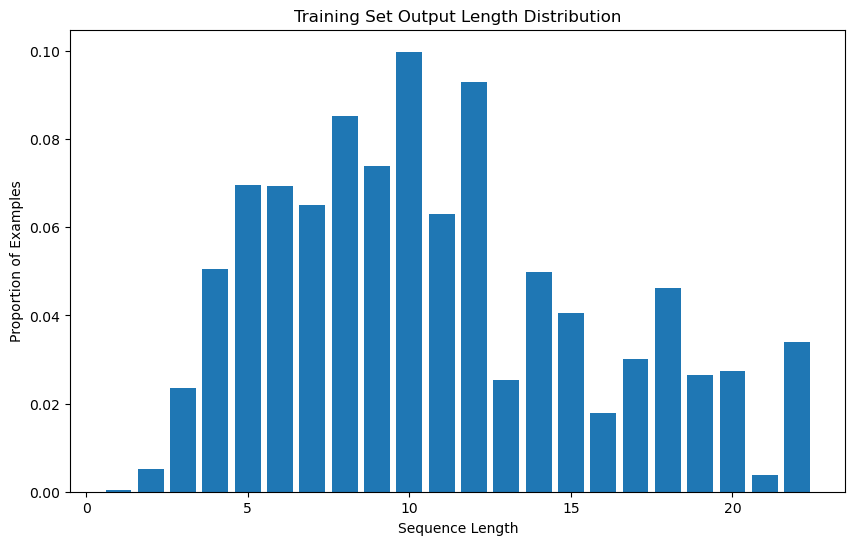

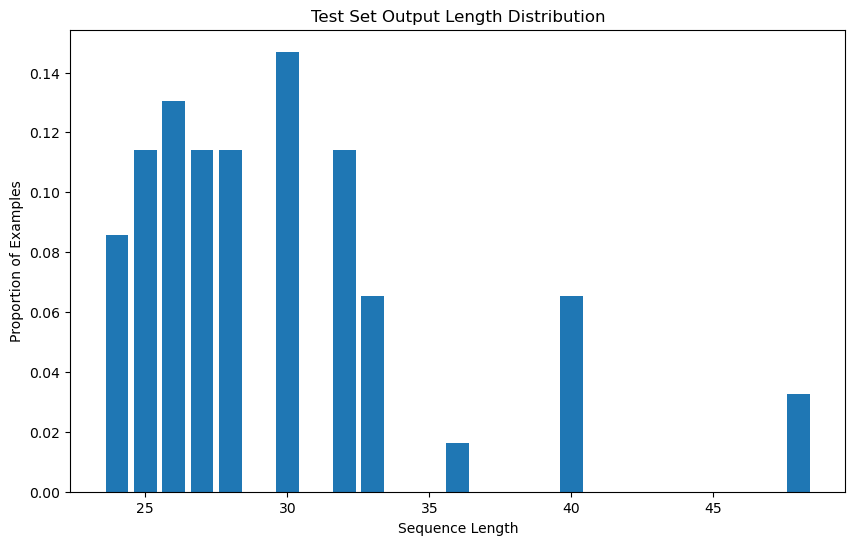

In [37]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

def plot_length_distribution(data, title, sequence_type='output'):
    if sequence_type == 'input':
        lengths = [len(in_seq) for in_seq, _ in data]
    elif sequence_type == 'output':
        lengths = [len(out_seq) for _, out_seq in data]
    else:
        raise ValueError("sequence_type must be either 'input' or 'output'")

    length_counts = Counter(lengths)
    total_examples = len(data)
    length_proportions = {length: count / total_examples for length, count in sorted(length_counts.items())}

    plt.figure(figsize=(10, 6))
    plt.bar(length_proportions.keys(), length_proportions.values())
    plt.xlabel("Sequence Length")
    plt.ylabel("Proportion of Examples")
    plt.title(title)
    plt.show()

plot_length_distribution(new_train_data, "Training Set Output Length Distribution", sequence_type='output')

plot_length_distribution(new_test_data, "Test Set Output Length Distribution", sequence_type='output')

## Exercise 6

Using the existing code, can you
- create loaders for the new training and test set reusing `SCANDataset`
- train a new GRU model on the new train set reusing `train_model`
- generate predicted sequences for the new GRU model reusing `evaluate_model`
- code a new function to measure to how the model performs on target sequences grouped by length in terms of exact match and BLEU.

Then answer the following questions:
- What effect do you expect shifts in distribution to have on model performance? Compare evaluation metrics of your experiments on o.o.d and i.i.d. generalisation.
- Is it realistic to expect these shifts in distribution in realistic settings where models are trained on natural language data?
- Is it realistic to expect compositional generalisation to be sufficient to model pairs of inputs and outputs in natural language?

In [39]:
BATCH_SIZE = 32

new_train_dataset = SCANDataset(new_train_data, input_w2i, output_w2i)
new_train_loader = DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

new_test_dataset = SCANDataset(new_test_data, input_w2i, output_w2i)
new_test_loader = DataLoader(new_test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [42]:
n_epochs = 5
lr = 0.001
new_gru_encoder, new_gru_decoder = train_model(f"{n_epochs}-{lr}--00D", n_epochs, lr)
new_sequences = evaluate_model(new_gru_encoder,new_gru_decoder,new_test_dataset,max_len=50)


100%|██████████| 523/523 [01:24<00:00,  6.17it/s]


loss,█▃▂▁▁
loss,2.19378


100%|██████████| 3920/3920 [01:02<00:00, 62.34it/s]


In [43]:
def exact_match_per_length(sequences):
    length2em = defaultdict(list)

    for predicted_tokens, reference_tokens in sequences:
        exact_match = int(predicted_tokens == reference_tokens)
        ref_len = len(reference_tokens)
        length2em[ref_len] += [exact_match]#按照不同length进行统计 length：[count1][count2][count3]

    # Compute accuracy per output length
    for length in sorted(length2em.keys()):
        acc = sum(length2em[length]) / len(length2em[length])
        print(f"Length {length:2d} | Accuracy: {acc:.3f}")

exact_match(new_sequences)
exact_match_per_length(new_sequences)

Exact match accuracy: 0.853
Length 24 | Accuracy: 0.869
Length 25 | Accuracy: 0.877
Length 26 | Accuracy: 0.889
Length 27 | Accuracy: 0.944
Length 28 | Accuracy: 0.786
Length 30 | Accuracy: 0.910
Length 32 | Accuracy: 0.848
Length 33 | Accuracy: 0.922
Length 36 | Accuracy: 0.422
Length 40 | Accuracy: 0.703
Length 48 | Accuracy: 0.633
